In [1]:
%config InlineBackend.figure_format = 'retina'
# %load_ext blackcellmagic

import sys
import math
import anndata
import numpy as np
from scipy import stats
from scipy import sparse
from scipy.io import mmread, mmwrite 
import pandas as pd
pd.set_option('display.max_colwidth', 0)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import logging
logger = logging.getLogger('matplotlib')
logger.setLevel(logging.WARNING)
import seaborn as sns

from tqdm import tqdm
TQDM_BAR_FORMAT = (
    "{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]"
)

import gget
import kb_python.utils as kb_utils

import scanpy as sc
sc.set_figure_params(figsize=(6, 6), frameon=False)
sc.settings.n_jobs=2

# Set random seed
np.random.seed(926)

def nd(arr):
    """
    Funciton to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

___

# Load data

In [2]:
all_adata = anndata.read(f"../COH_data/alignment_v2/all_norm_celltypes.h5ad")
all_adata

AnnData object with n_obs × n_vars = 80934 × 27394
    obs: 'species', 'tissue', 'library_id', 'sample', 'percent_mito', 'n_counts', 'n_genes', 'cell_barcode_x', 'donor_id_x', 'cell_barcode_y', 'donor_id_y', 'cell_barcode', 'donor', 'donor_id', 'barcode', 'timepoint', 'leiden', 'celltype'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_symbol'
    uns: 'dendrogram_celltype', 'dendrogram_leiden', 'dendrogram_sample', 'dendrogram_timepoint', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [3]:
tcell_adata = all_adata[np.char.startswith(nd(all_adata.obs.celltype.values).astype(str), "T cells")].copy()
tcell_adata

AnnData object with n_obs × n_vars = 41462 × 27394
    obs: 'species', 'tissue', 'library_id', 'sample', 'percent_mito', 'n_counts', 'n_genes', 'cell_barcode_x', 'donor_id_x', 'cell_barcode_y', 'donor_id_y', 'cell_barcode', 'donor', 'donor_id', 'barcode', 'timepoint', 'leiden', 'celltype'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_symbol'
    uns: 'dendrogram_celltype', 'dendrogram_leiden', 'dendrogram_sample', 'dendrogram_timepoint', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

___

# Create marker gene list

Immune landscape markers from https://www.cell.com/action/showPdf?pii=S1535-6108%2823%2900036-3 Fig. 1C:

In [4]:
tcell_markers = ["CD4", "CCR7", "SESN3", "LTB", "FOXP3", "CD8A", "CD8B", "NELL2", "ZEB2", "TYROBP", "CX3CR1", "PTPRC", "PRF1", "GZMK", "TOX", "MKI67", "KLRB1", "TRDV1"]

Get Ensembl IDs from gene symbols using gget:

In [5]:
search_results = gget.search(tcell_markers, species="human")

# Filter gget results for exact matches and protein-coding biotypes
tcell_df = search_results[search_results["gene_name"].isin(tcell_markers)][(search_results["biotype"] == "protein_coding") | (search_results["biotype"] == "TR_V_gene")]

Fri Sep  8 02:34:49 2023 INFO Fetching results from database: homo_sapiens_core_110_38
Fri Sep  8 02:35:25 2023 INFO Total matches found: 176.
Fri Sep  8 02:35:25 2023 INFO Query time: 44.35 seconds.


In [6]:
# Only keep markers also present in adata
tcell_ens = [marker for marker in tcell_df["ensembl_id"] if marker in all_adata.var.index]

# Display genes
tcell_df[tcell_df["ensembl_id"].isin(tcell_ens)].reset_index(drop=True)

,ensembl_id,gene_name,ensembl_description,ext_ref_description,biotype,synonym,url
0,ENSG00000010610,CD4,CD4 molecule [Source:HGNC Symbol;Acc:HGNC:1678],CD4 molecule,protein_coding,[None],https://useast.ensembl.org/homo_sapiens/Gene/Summary?g=ENSG00000010610
1,ENSG00000011600,TYROBP,transmembrane immune signaling adaptor TYROBP [Source:HGNC Symbol;Acc:HGNC:12449],transmembrane immune signaling adaptor TYROBP,protein_coding,"[DAP12, KARAP, PLO-SL, PLOSL]",https://useast.ensembl.org/homo_sapiens/Gene/Summary?g=ENSG00000011600
2,ENSG00000049768,FOXP3,forkhead box P3 [Source:HGNC Symbol;Acc:HGNC:6106],forkhead box P3,protein_coding,"[AIID, DIETER, IPEX, JM2, PIDX, SCURFIN, XPID]",https://useast.ensembl.org/homo_sapiens/Gene/Summary?g=ENSG00000049768
3,ENSG00000081237,PTPRC,protein tyrosine phosphatase receptor type C [Source:HGNC Symbol;Acc:HGNC:9666],protein tyrosine phosphatase receptor type C,protein_coding,"[CD45, GP180, LCA, T200]",https://useast.ensembl.org/homo_sapiens/Gene/Summary?g=ENSG00000081237
4,ENSG00000111796,KLRB1,killer cell lectin like receptor B1 [Source:HGNC Symbol;Acc:HGNC:6373],killer cell lectin like receptor B1,protein_coding,"[CD161, CLEC5B, HNKR-P1A, NKR, NKR-P1, NKR-P1A]",https://useast.ensembl.org/homo_sapiens/Gene/Summary?g=ENSG00000111796
5,ENSG00000113088,GZMK,granzyme K [Source:HGNC Symbol;Acc:HGNC:4711],granzyme K,protein_coding,"[PRSS, TRYP2]",https://useast.ensembl.org/homo_sapiens/Gene/Summary?g=ENSG00000113088
6,ENSG00000126353,CCR7,C-C motif chemokine receptor 7 [Source:HGNC Symbol;Acc:HGNC:1608],C-C motif chemokine receptor 7,protein_coding,"[BLR2, CD197, CDW197, CMKBR7, EBI1]",https://useast.ensembl.org/homo_sapiens/Gene/Summary?g=ENSG00000126353
7,ENSG00000148773,MKI67,marker of proliferation Ki-67 [Source:HGNC Symbol;Acc:HGNC:7107],marker of proliferation Ki-67,protein_coding,"[KI-67, MIB-1, PPP1R105]",https://useast.ensembl.org/homo_sapiens/Gene/Summary?g=ENSG00000148773
8,ENSG00000149212,SESN3,sestrin 3 [Source:HGNC Symbol;Acc:HGNC:23060],sestrin 3,protein_coding,"[MGC29667, SEST3]",https://useast.ensembl.org/homo_sapiens/Gene/Summary?g=ENSG00000149212
9,ENSG00000153563,CD8A,CD8 subunit alpha [Source:HGNC Symbol;Acc:HGNC:1706],CD8 subunit alpha,protein_coding,"[CD8, CD8ALPHA, P32]",https://useast.ensembl.org/homo_sapiens/Gene/Summary?g=ENSG00000153563


___

# Define immune cell type based on thresholded marker gene expression

Note: Using log-normalized versus raw counts with threshold=0 leads to same results, but using raw counts computes faster.

For adata object containing only previously filtered T cells:

In [11]:
def immune_thresholds(adata, i, threshold):
    labels = []

    if adata.raw[i, adata.var.index == "ENSG00000010610"].X.sum() > threshold and adata.raw[i, adata.var.index == "ENSG00000126353"].X.sum() > threshold:
        labels.append("CD4_naïve_CCR7")

    if adata.raw[i, adata.var.index == "ENSG00000010610"].X.sum() > threshold and adata.raw[i, adata.var.index == "ENSG00000149212"].X.sum() > threshold:
        labels.append("CD4_quiescent_SESN3")

    if adata.raw[i, adata.var.index == "ENSG00000010610"].X.sum() > threshold and adata.raw[i, adata.var.index == "ENSG00000227507"].X.sum() > threshold:
        labels.append("CD4_memory_LTB")

    if adata.raw[i, adata.var.index == "ENSG00000049768"].X.sum() > threshold:
        labels.append("Treg_FOXP3")

    if adata.raw[i, adata.var.index == "ENSG00000010610"].X.sum() > threshold and (adata.raw[i, adata.var.index == "ENSG00000153563"].X.sum() > threshold and adata.raw[i, adata.var.index == "ENSG00000172116"].X.sum() > threshold):
        labels.append("CD4_CD8_DB")

    if adata.raw[i, adata.var.index == "ENSG00000184613"].X.sum() > threshold and (adata.raw[i, adata.var.index == "ENSG00000153563"].X.sum() > threshold or adata.raw[i, adata.var.index == "ENSG00000172116"].X.sum() > threshold):
        labels.append("CD8_naïve_NELL2")

    if adata.raw[i, adata.var.index == "ENSG00000169554"].X.sum() > threshold and (adata.raw[i, adata.var.index == "ENSG00000153563"].X.sum() > threshold or adata.raw[i, adata.var.index == "ENSG00000172116"].X.sum() > threshold):
        labels.append("CD8_effector_ZEB2")

    if adata.raw[i, adata.var.index == "ENSG00000011600"].X.sum() > threshold and (adata.raw[i, adata.var.index == "ENSG00000153563"].X.sum() > threshold or adata.raw[i, adata.var.index == "ENSG00000172116"].X.sum() > threshold):
        labels.append("CD8_effector_TYROBP")

    if adata.raw[i, adata.var.index == "ENSG00000168329"].X.sum() > threshold and (adata.raw[i, adata.var.index == "ENSG00000153563"].X.sum() > threshold or adata.raw[i, adata.var.index == "ENSG00000172116"].X.sum() > threshold):
        labels.append("CD8_effector_CX3CR1")

    if adata.raw[i, adata.var.index == "ENSG00000081237"].X.sum() > threshold and adata.raw[i, adata.var.index == "ENSG00000180644"].X.sum() > threshold and (adata.raw[i, adata.var.index == "ENSG00000153563"].X.sum() > threshold or adata.raw[i, adata.var.index == "ENSG00000172116"].X.sum() > threshold):
        labels.append("CD8_EMRA_PRF1")

    if adata.raw[i, adata.var.index == "ENSG00000113088"].X.sum() > threshold and (adata.raw[i, adata.var.index == "ENSG00000153563"].X.sum() > threshold or adata.raw[i, adata.var.index == "ENSG00000172116"].X.sum() > threshold):
        labels.append("CD8_EM_GZMK")

    if adata.raw[i, adata.var.index == "ENSG00000198846"].X.sum() > threshold and (adata.raw[i, adata.var.index == "ENSG00000153563"].X.sum() > threshold or adata.raw[i, adata.var.index == "ENSG00000172116"].X.sum() > threshold):
        labels.append("CD8_exhausted-like_TOX")

    if adata.raw[i, adata.var.index == "ENSG00000148773"].X.sum() > threshold and (adata.raw[i, adata.var.index == "ENSG00000153563"].X.sum() > threshold or adata.raw[i, adata.var.index == "ENSG00000172116"].X.sum() > threshold):
        labels.append("CD8_proliferating_MKI67")

    if adata.raw[i, adata.var.index == "ENSG00000111796"].X.sum() > threshold:
        labels.append("MAIT_KLRB1")

    if adata.raw[i, adata.var.index == "ENSG00000211804"].X.sum() > threshold:
        labels.append("γδ_T_TRDV1")
        
    return labels

def def_immune_celltypes(adata):
    with tqdm(total=len(adata), bar_format=TQDM_BAR_FORMAT) as pbar:
        pbar.set_description("Threshold 1/3 (> 0)")
        
        for i in np.arange(len(adata)):
            labels = immune_thresholds(adata, i, threshold = 0)

            if labels:
                adata.obs.loc[adata.obs.index[i], "immune_comp_raw"] = "+".join(labels)

            pbar.update(n=1)
            
    # Rerun cells that mapped to multiple celltypes with a higher threshold
    with tqdm(total=len(adata), bar_format=TQDM_BAR_FORMAT) as pbar:
        pbar.set_description("Threshold 2/3 (> 1)")
        
        for i in np.arange(len(adata)):
            try:
                if "+" in adata.obs.iloc[i]["immune_comp_raw"]:
                    labels = immune_thresholds(adata, i, threshold = 1)

                    if labels:
                        adata.obs.loc[adata.obs.index[i], "immune_comp_raw"] = "+".join(labels)
            except:
                pass

            pbar.update(n=1)
            
    with tqdm(total=len(adata), bar_format=TQDM_BAR_FORMAT) as pbar:
        pbar.set_description("Threshold 3/3 (> 2)")
        
        for i in np.arange(len(adata)):
            try:
                if "+" in adata.obs.iloc[i]["immune_comp_raw"]:
                    labels = immune_thresholds(adata, i, threshold = 2)

                    if labels:
                        adata.obs.loc[adata.obs.index[i], "immune_comp_raw"] = "+".join(labels)
            except:
                pass

            pbar.update(n=1)
            
    return adata

In [12]:
%%time
tcell_adata.obs["immune_comp_raw"] = [None] * tcell_adata.n_obs

tcell_adata = def_immune_celltypes(tcell_adata)

# Save adata containing celltype assignments
tcell_adata.write("../COH_data/alignment_v2/tcell_immune_landscape.h5ad")

Threshold 3/3 (> 2): 100%|███████| 41462/41462 [elapsed: 05:40 remaining: 00:00]


CPU times: user 39min 11s, sys: 15.2 s, total: 39min 26s
Wall time: 39min 16s


In [5]:
tcell_adata = anndata.read("../COH_data/alignment_v2/tcell_immune_landscape.h5ad")

Print results from each thresholding method:

In [6]:
immune_cells = [
    "CD4_naïve_CCR7", 
    "CD4_quiescent_SESN3", 
    "CD4_memory_LTB", 
    "Treg_FOXP3", 
    "CD4_CD8_DB", 
    "CD8_naïve_NELL2", 
    "CD8_effector_ZEB2", 
    "CD8_effector_TYROBP", 
    "CD8_effector_CX3CR1",
    "CD8_EMRA_PRF1",
    "CD8_EM_GZMK",
    "CD8_exhausted-like_TOX",
    "CD8_proliferating_MKI67",
    "MAIT_KLRB1",
    "γδ_T_TRDV1"
]

In [7]:
print("Total cell type combinations: ", len(tcell_adata.obs["immune_comp_raw"].unique()))
print("# cells with no label: ", len(tcell_adata.obs[tcell_adata.obs["immune_comp_raw"].isnull()]))

Total cell type combinations:  437
# cells with no label:  19061


In [8]:
for celltype in immune_cells:
    print(celltype)
    print("# cells unambigiously defined: ", len(tcell_adata.obs[tcell_adata.obs["immune_comp_raw"] == celltype]))

CD4_naïve_CCR7
# cells unambigiously defined:  49
CD4_quiescent_SESN3
# cells unambigiously defined:  1
CD4_memory_LTB
# cells unambigiously defined:  2504
Treg_FOXP3
# cells unambigiously defined:  868
CD4_CD8_DB
# cells unambigiously defined:  1
CD8_naïve_NELL2
# cells unambigiously defined:  247
CD8_effector_ZEB2
# cells unambigiously defined:  205
CD8_effector_TYROBP
# cells unambigiously defined:  910
CD8_effector_CX3CR1
# cells unambigiously defined:  424
CD8_EMRA_PRF1
# cells unambigiously defined:  1586
CD8_EM_GZMK
# cells unambigiously defined:  1117
CD8_exhausted-like_TOX
# cells unambigiously defined:  134
CD8_proliferating_MKI67
# cells unambigiously defined:  2099
MAIT_KLRB1
# cells unambigiously defined:  3386
γδ_T_TRDV1
# cells unambigiously defined:  594


___

# Plot results

Were same celltype cells clustered together?

In [9]:
def fill_between_bars(ax, colors):
    bottoms = []
    tops = []
    for patch in ax.patches:
        x,y = patch.get_xy()
        w,h = patch.get_width(), patch.get_height()

        bottoms += [(x,y), (x+w, y)]
        tops += [(x, y+h), (x+w, y+h)]

    # convert to numpy for easy slicing
    tops = np.array(tops)
    bottoms = np.array(bottoms)

    # extract the x coordinates
    x = np.unique(bottoms[:,0])
    num_x = len(x)

    # fill between each bottom and top pairs
    color_idx = 0
    for i in range(0, len(bottoms), num_x):
        ax.fill_between(x, tops[i:i+num_x, 1], bottoms[i:i+num_x, 1], alpha=0.25, lw=0, color=colors[color_idx])
        color_idx += 1

In [10]:
fontsize=12

def plot_fraction_per_sample(
    adata,
    groups="leiden",
    group_order=None,
    fractions="sample",
    save_as="test",
    normalize_to_total=False,
    title=None,
    colors=[],
    xticklabel_rotation=0,
    figsize=None,
    legend_on_bottom=False,
    save=False,
    connect_bars=False
):
    ## Save fractions to plot in dataframe
    # Convert sample column to string (instead of categorical)
    adata.obs[fractions] = adata.obs[fractions].astype(str)

    df_normalized = pd.DataFrame()

    if normalize_to_total:
        # Normalize each celltype count to total number of cells in that batch by dividing
        df_normalized = (
            (
                adata.obs.groupby(groups)[fractions].value_counts()
                / adata.obs.groupby(fractions)["species"].count()
            )
            .unstack()
            .fillna(0)
        )
        # Convert columns to string
        df_normalized.columns = df_normalized.columns.astype(str)
        # Get total normalized count
        df_normalized["total_normalized_count"] = df_normalized.sum(axis=1).values

        # Compute fraction of normalized total count for each sample
        for sample in adata.obs[fractions].unique():
            df_normalized[f"{sample}_fraction"] = (
                df_normalized[sample] / df_normalized["total_normalized_count"]
            ).values

    else:
        # Do not normalize to total count (use if we do not expect these to be equally distributed across the clusters, e.g. for donor)
        df_normalized = (
            adata.obs.groupby(groups)[fractions].value_counts().unstack().fillna(0)
        )
        df_normalized["total_count"] = df_normalized.sum(axis=1).values

        for sample in df_normalized.columns[:-1]:
            df_normalized[f"{sample}_fraction"] = (
                df_normalized[sample] / df_normalized["total_count"]
            ).values

    # Get total cellcount
    df_normalized["total_cellcount"] = (
        adata.obs.groupby(groups).size().values.astype(int)
    )
    
    # Sort data
    if group_order:
        df_normalized = df_normalized.reindex(group_order)
    
    ## Plot
    if figsize:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig, ax = plt.subplots(figsize=(15, 4))
        
    width = 0.7
    alpha = 1

    clusters = df_normalized.index.values
    cellcounts = df_normalized["total_cellcount"].values

    previous_samples = 0
    
    # Sort fractions
    fracs = adata.obs[fractions].unique()
    fracs = np.sort(fracs)

    for i, sample in enumerate(fracs):
        ax.bar(
            clusters,
            df_normalized[f"{sample}_fraction"].values,
            width,
            bottom=previous_samples,
            color=colors[i] if colors else None,
            label=sample,
            alpha=alpha,
        )
        previous_samples = previous_samples + df_normalized[f"{sample}_fraction"].values

    # Add value above each bar
    for index, value in enumerate(cellcounts):
        ax.text(x=index, y=1.01, s=value, size=fontsize-1, ha="center")

    if xticklabel_rotation == 0:
        ax.set_xticklabels(clusters)
    else:
        ax.set_xticklabels(clusters, rotation=xticklabel_rotation, ha="right")
        
    if connect_bars:
        fill_between_bars(ax, colors=colors)

    if legend_on_bottom:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=math.ceil(len(fracs)/2), fontsize=fontsize)
    else:
        ax.legend(bbox_to_anchor=(1.001, 1.025), loc="upper left", fontsize=fontsize)

    ax.set_title(title, y=1.0, pad=20, fontsize=fontsize + 2)
    ax.set_ylabel("Fraction of cells", fontsize=fontsize)
    if "leiden" in groups:
        ax.set_xlabel("Leiden cluster", fontsize=fontsize)
    else:
        ax.set_xlabel(groups.capitalize(), fontsize=fontsize)
    ax.tick_params(axis="both", labelsize=fontsize)

    # ax.axhline(y=0.25, color="grey", linestyle="--")
    # ax.axhline(y=0.5, color="grey", linestyle="--")
    # ax.axhline(y=0.75, color="grey", linestyle="--")

    ax.margins(x=0.01, y=0.06)
    ax.grid(False)

    plt.tight_layout()

    if save:
        plt.savefig(
            f"figures/3_{save_as}.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"figures/3_{save_as}.svg",
            dpi=300,
            bbox_inches="tight",
        )

    fig.show()

In [11]:
# plot_fraction_per_sample(
#     all_adata,
#     groups="immune_comp_scvi",
#     fractions="leiden",
#     normalize_to_total=False,
#     xticklabel_rotation=45,
#     title="Fraction of scvi-assigned immune cells in each Leiden cluster - all data",
# ) 

In [12]:
# plot_fraction_per_sample(
#     tcell_adata,
#     groups="immune_comp_scvi",
#     fractions="leiden",
#     normalize_to_total=False,
#     xticklabel_rotation=45,
#     title="Fraction of scvi-assigned immune cells in each Leiden cluster - T cell clusters only",
#     figsize=(10,5)
# ) 

In [13]:
# plot_fraction_per_sample(
#     tcell_adata,
#     groups="immune_comp_scvi2",
#     fractions="leiden",
#     normalize_to_total=False,
#     xticklabel_rotation=45,
#     title="Fraction of scvi-assigned immune cells in each Leiden cluster - T cell clusters only",
#     figsize=(10,5)
# ) 

Same for celltype identified by hardcoded threshold:

In [14]:
# Only keep labels from immune_comp_raw2 that matched a single celltype
clean_raw = []
for celltype in tcell_adata.obs["immune_comp_raw"].values:
    try:
        # This won't work for np.nan values, hence the try except clause
        if "+" in celltype:
            clean_raw.append(np.nan)
        else:
            clean_raw.append(celltype)
    except:
        clean_raw.append(celltype)
        
tcell_adata.obs["immune_comp_raw_clean"] = clean_raw

# clean_raw = []
# for celltype in all_adata.obs["immune_comp_raw"].values:
#     try:
#         # This won't work for np.nan values, hence the try except clause
#         if "+" in celltype:
#             clean_raw.append(np.nan)
#         else:
#             clean_raw.append(celltype)
#     except:
#         clean_raw.append(celltype)
        
# all_adata.obs["immune_comp_raw_clean"] = clean_raw

In [15]:
# plot_fraction_per_sample(
#     all_adata,
#     groups="immune_comp_raw_clean",
#     fractions="celltype",
#     normalize_to_total=False,
#     xticklabel_rotation=45,
#     title="Fraction of manually assigned immune cells in each Leiden cluster - all clusters",
# )

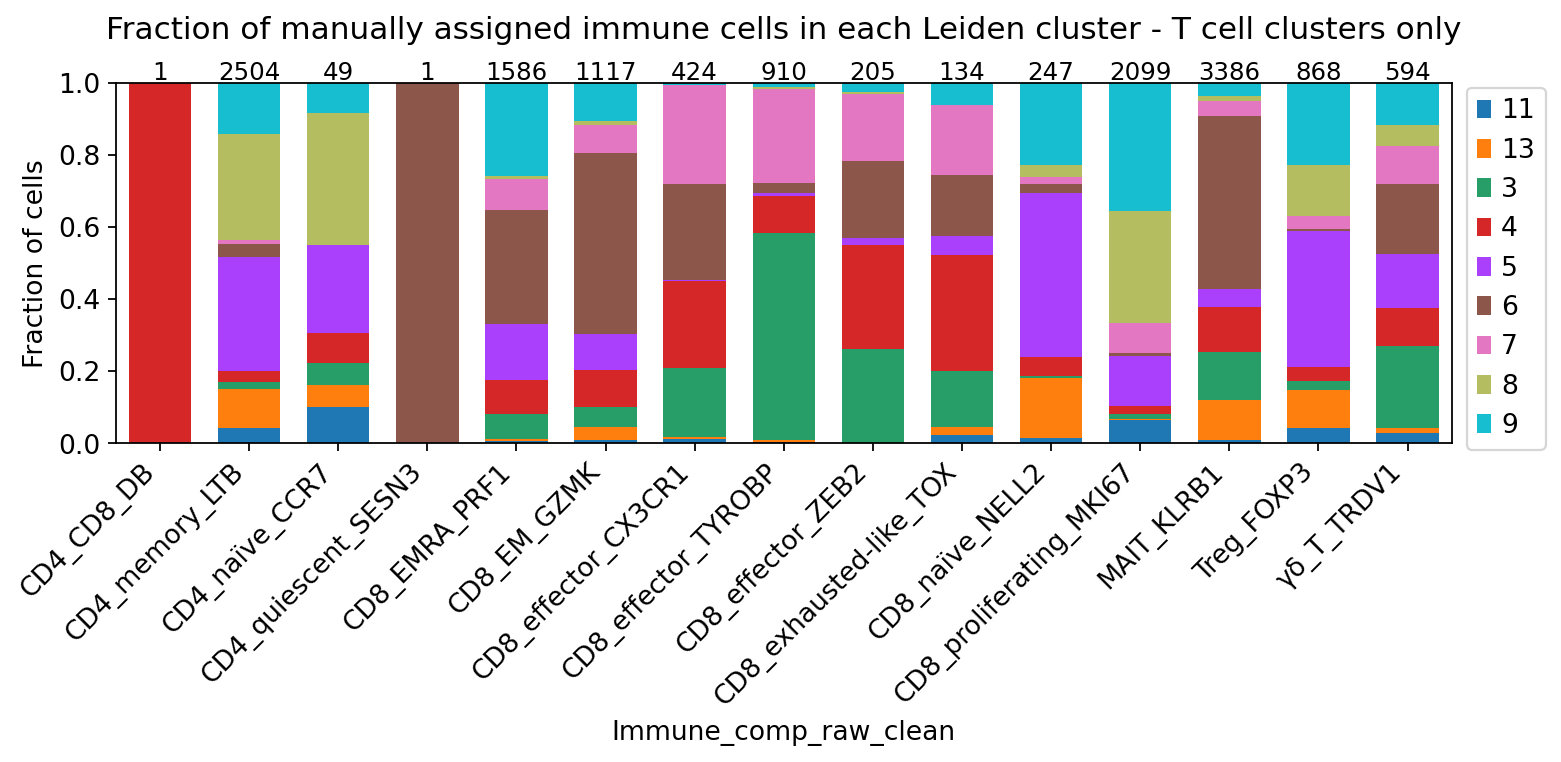

In [16]:
plot_fraction_per_sample(
    tcell_adata,
    groups="immune_comp_raw_clean",
    fractions="leiden",
    normalize_to_total=False,
    xticklabel_rotation=45,
    title="Fraction of manually assigned immune cells in each Leiden cluster - T cell clusters only",
    figsize=(10,5)
)

Plot how often manual and scVI mapping matched:

In [17]:
# df = all_adata.obs
# confusion_matrix = pd.crosstab(
#     df["immune_comp_scvi"],
#     df["immune_comp_raw_clean"],
#     rownames=["scVI-tools predictions"],
#     colnames=["Manual predictions"],
# )
# confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)
# fig, ax = plt.subplots(figsize=(5, 4))
# sns.heatmap(
#     confusion_matrix,
#     cmap=sns.diverging_palette(245, 320, s=60, as_cmap=True),
#     ax=ax,
#     square=True,
#     cbar_kws=dict(shrink=0.4, aspect=12),
# )
# fig.show()

In [18]:
# df = tcell_adata.obs
# confusion_matrix = pd.crosstab(
#     df["immune_comp_scvi"],
#     df["immune_comp_raw_clean"],
#     rownames=["scVI-tools predictions"],
#     colnames=["Manual predictions"],
# )
# confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)
# fig, ax = plt.subplots(figsize=(5, 4))
# sns.heatmap(
#     confusion_matrix,
#     cmap=sns.diverging_palette(245, 320, s=60, as_cmap=True),
#     ax=ax,
#     square=True,
#     cbar_kws=dict(shrink=0.4, aspect=12),
# )
# fig.show()

In [19]:
# df = tcell_adata.obs
# confusion_matrix = pd.crosstab(
#     df["immune_comp_scvi"],
#     df["immune_comp_raw_clean"],
#     rownames=["scVI-tools predictions"],
#     colnames=["Manual predictions"],
# )
# confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)
# fig, ax = plt.subplots(figsize=(5, 4))
# sns.heatmap(
#     confusion_matrix,
#     cmap=sns.diverging_palette(245, 320, s=60, as_cmap=True),
#     ax=ax,
#     square=True,
#     cbar_kws=dict(shrink=0.4, aspect=12),
# )
# fig.show()

In [20]:
# Function to insert row in the dataframe
def Insert_row_(row_number, df, row_value):
    # Slice the upper half of the dataframe
    df1 = df[0:row_number]
  
    # Store the result of lower half of the dataframe
    df2 = df[row_number:]
  
    # Insert the row in the upper half dataframe
    df1.loc[row_number]=row_value
  
    # Concat the two dataframes
    df_result = pd.concat([df1, df2])
  
    # Reassign the index labels
    df_result.index = [*range(df_result.shape[0])]
  
    # Return the updated dataframe
    return df_result

In [21]:
# df = tcell_adata.obs
# confusion_matrix = pd.crosstab(
#     df["immune_comp_scvi"],
#     df["immune_comp_raw_clean"],
#     rownames=["CellAssign predictions"],
#     colnames=["Threshold-based predictions"],
# )


# ## Edit confusion matrix because some cell types only exist in manual/scvi
# confusion_matrix = confusion_matrix.reset_index()

# # Add CD4_CD8_DB row
# row_number = 0
# row_value = ["CD4_CD8_DB"] + list(np.zeros(len(confusion_matrix.columns))[1:])
 
# confusion_matrix = Insert_row_(row_number, confusion_matrix, row_value)

# # Add CD4_naïve_CCR7 row
# row_number = 2
# row_value = ["CD4_naïve_CCR7"] + list(np.zeros(len(confusion_matrix.columns))[1:])
 
# confusion_matrix = Insert_row_(row_number, confusion_matrix, row_value)

# # Add CD4_quiescent_SESN3 columns
# confusion_matrix.insert(3, "CD4_quiescent_SESN3", np.zeros(len(confusion_matrix)))

# confusion_matrix = confusion_matrix.set_index("CellAssign predictions")


# # Plot confusion matrix
# confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)
# confusion_matrix = confusion_matrix.fillna(0)
# fig, ax = plt.subplots(figsize=(10, 8))
# sns.heatmap(
#     confusion_matrix,
#     cmap=sns.diverging_palette(245, 320, s=60, as_cmap=True),
#     ax=ax,
#     square=True,
#     cbar_kws=dict(shrink=0.4, aspect=12),
#     xticklabels=True, 
#     yticklabels=True
# )
# fig.show()

In [22]:
# df = tcell_adata.obs
# confusion_matrix = pd.crosstab(
#     df["immune_comp_scvi2"],
#     df["immune_comp_raw_clean"],
#     rownames=["CellAssign predictions v2"],
#     colnames=["Threshold-based predictions"],
# )

# ## Edit confusion matrix because some cell types only exist in manual/scvi
# confusion_matrix = confusion_matrix.reset_index()

# # # Add other row
# # row_number = -1
# # row_value = ["other"] + list(np.zeros(len(confusion_matrix.columns))[1:])
 
# # confusion_matrix = Insert_row_(row_number, confusion_matrix, row_value)

# # Add CD4_CD8_DB_resting and CD4_quiescent_SESN3 columns
# confusion_matrix.insert(2, "CD4_CD8_DB_resting", np.zeros(len(confusion_matrix)))
# confusion_matrix.insert(5, "CD4_quiescent_SESN3", np.zeros(len(confusion_matrix)))

# confusion_matrix = confusion_matrix.set_index("CellAssign predictions v2")


# confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)
# fig, ax = plt.subplots(figsize=(10, 8))
# sns.heatmap(
#     confusion_matrix,
#     cmap=sns.diverging_palette(245, 320, s=60, as_cmap=True),
#     ax=ax,
#     square=True,
#     cbar_kws=dict(shrink=0.4, aspect=12),
#     xticklabels=True, 
#     yticklabels=True
# )
# fig.show()

___

# Confirm labels based on marker gene expression

In [23]:
marker_gene_mat = pd.read_excel("../COH/immune_landscape_markers_v2.xlsx")

# Clean up marker gene matrix
marker_gene_names = marker_gene_mat["Gene name"].values # Save for later
marker_gene_mat = marker_gene_mat.drop("Gene name", axis=1)
marker_gene_mat = marker_gene_mat.set_index("Ensembl ID", drop=True)
marker_gene_mat = marker_gene_mat.fillna(0)
marker_gene_mat["other"] = 0
marker_gene_mat = marker_gene_mat.astype(int)

marker_gene_mat

,CD4_naïve_CCR7,CD4_quiescent_SESN3,CD4_memory_LTB,Treg_FOXP3,CD4_CD8_DB,CD4_CD8_DB_resting,CD8_naïve_NELL2,CD8_effector_ZEB2,CD8_effector_TYROBP,CD8_effector_CX3CR1,CD8_EMRA_PRF1,CD8_EM_GZMK,CD8_exhausted-like_TOX,CD8_proliferating_MKI67,MAIT_KLRB1,γδ_T_TRDV1,other
Ensembl ID,,,,,,,,,,,,,,,,,
ENSG00000010610,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0
ENSG00000126353,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
ENSG00000138795,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
ENSG00000081059,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
ENSG00000188404,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
ENSG00000127528,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000149212,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000227507,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000049768,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
def plot_marker_gene_exp(adata, groupby, var_grouping, var_labels, var_positions):
    
    markers = marker_gene_mat.index.values
    temp_var_labels = [""]

    ax = sc.pl.dotplot(
        adata,
        markers,
        groupby=groupby,
        use_raw=False,
        # dendrogram=True,
        var_group_positions=var_grouping,
        var_group_labels=temp_var_labels,
        var_group_rotation=45,
        swap_axes=False,
        standard_scale=None,
        show=False,
    )
    
    # ax["mainplot_ax"].set_title(f"Expression of marker genes in {'-'.join(adata.obs['tissue'][0].split('/'))} dataset", pad=120)
    
    ## Rotate var labels
    # Get initial label positions from: ax["gene_group_ax"].properties()["children"]
    if var_grouping is not None:
        for position, label in zip(var_positions, var_labels):
            ax["gene_group_ax"].text(position, 1.1, label, rotation=45, ha="left")

    ax["mainplot_ax"].set_xticklabels(
        list(markers + " - " + marker_gene_names), 
        rotation=45, ha="right",)

    plt.tight_layout()
                                    
    # Save plot
    plt.savefig(f"figures/3_donor388_immune_landscape_{groupby}_marker-gene-expression.png", dpi=300, bbox_inches="tight")
    plt.savefig(f"figures/3_donor388_immune_landscape_{groupby}_marker-gene-expression.svg", dpi=300, bbox_inches="tight")

In [25]:
# plot_marker_gene_exp(
#         tcell_adata,
#         groupby="immune_comp_scvi2",
#         var_grouping=[(0,0)],
#         var_labels=[""],
#         var_positions = [0]
#     )

In [26]:
# plot_marker_gene_exp(
#         tcell_adata,
#         groupby="immune_comp_scvi",
#         var_grouping=[(0,0)],
#         var_labels=[""],
#         var_positions = [0]
#     )

In [47]:
celltypes_to_skip = [
    "CD4_CD8_DB",
    "Treg_FOXP3", 
    "MAIT_KLRB1",
    "γδ_T_TRDV1"
]

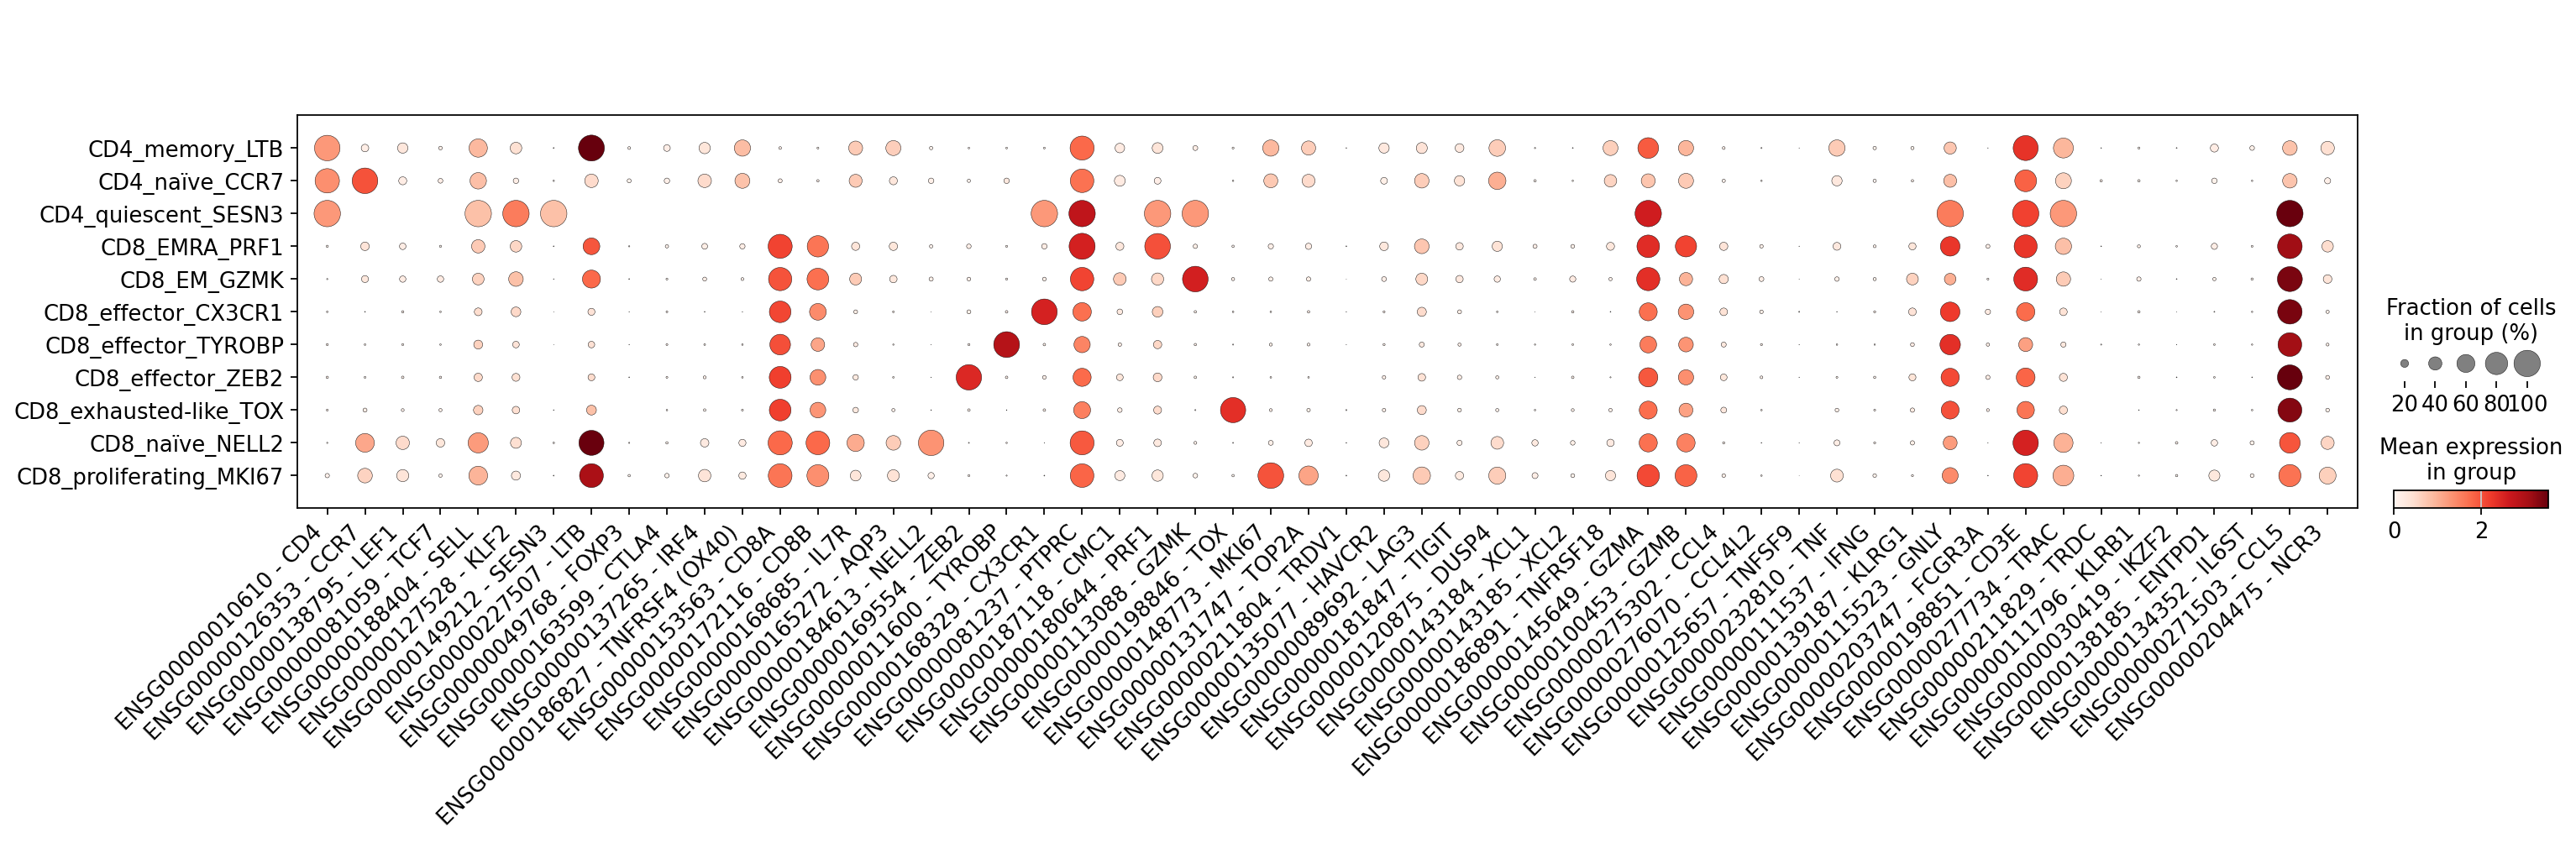

In [48]:
plot_marker_gene_exp(
        tcell_adata[~tcell_adata.obs["immune_comp_raw_clean"].isin(celltypes_to_skip)],
        groupby="immune_comp_raw_clean",
        var_grouping=None,
        var_labels=[""],
        var_positions = [0]
    )

___

# Plot changes to immune landscape over time across patients

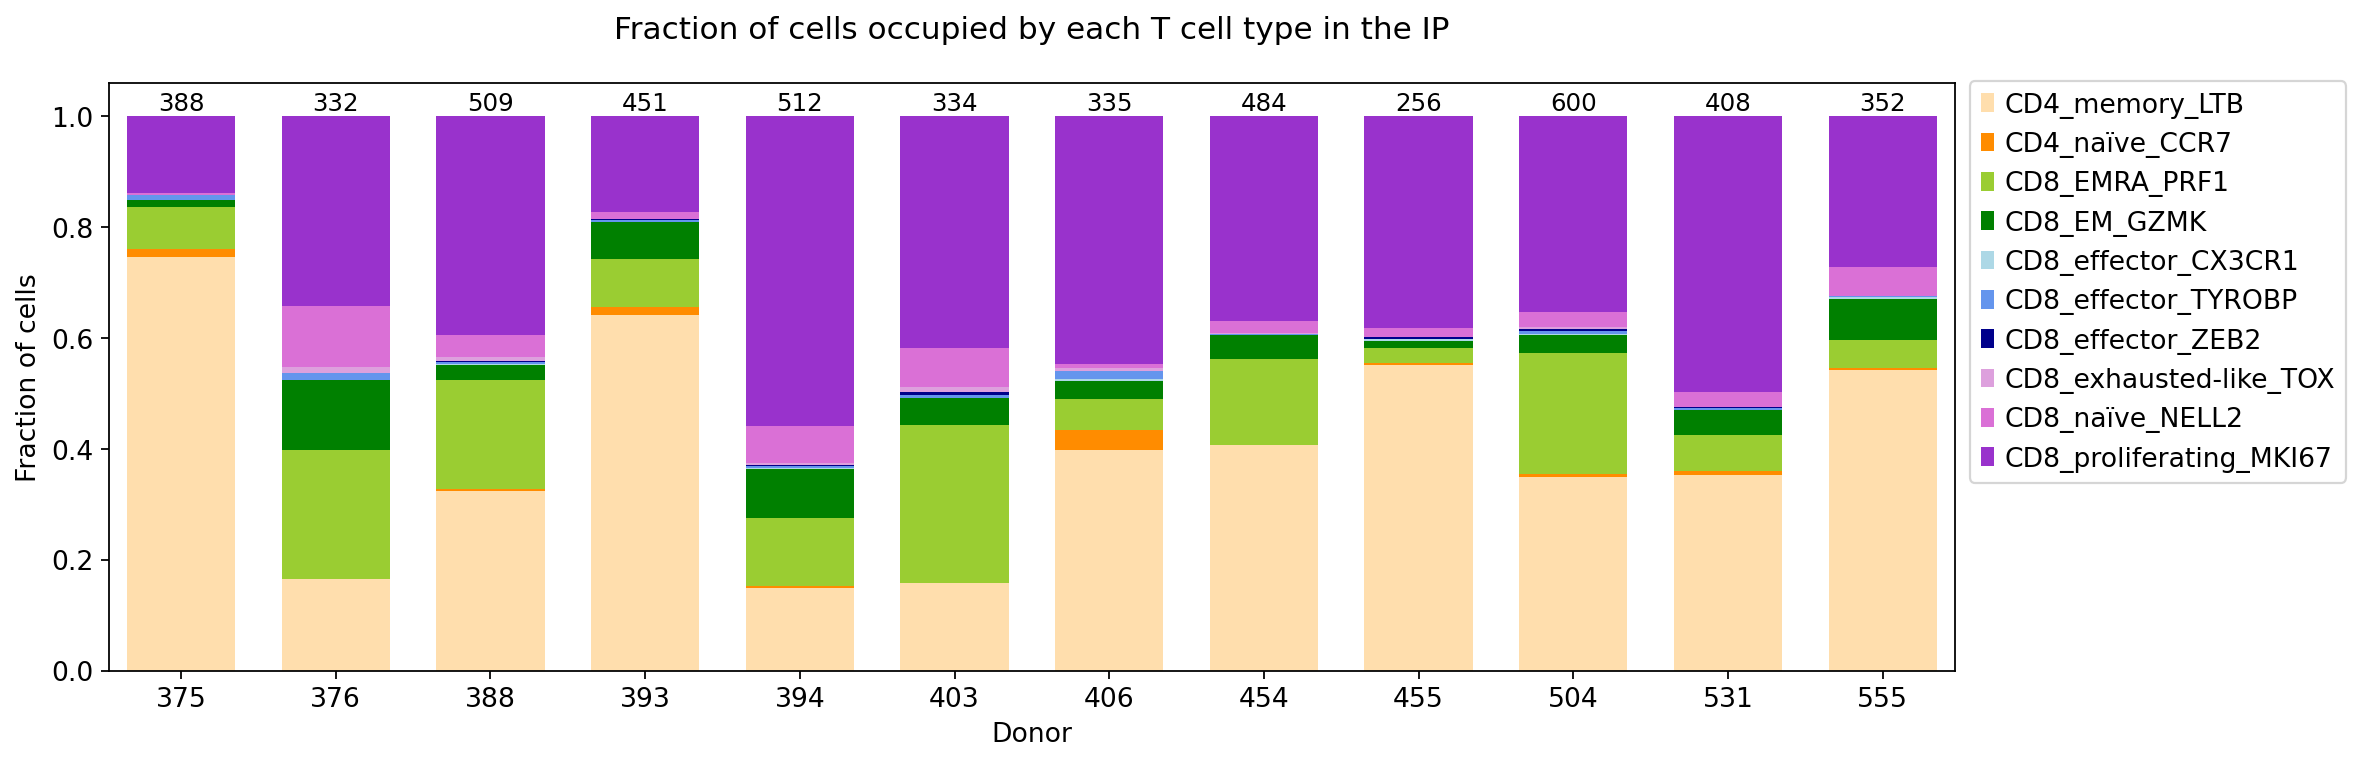

In [35]:
timepoint = "IP"
colors = ["navajowhite", "darkorange", "yellowgreen", "green", "lightblue", "cornflowerblue", "darkblue", "plum", "orchid", "darkorchid", "paleturquoise", "teal", "lightgrey", "lightpink"]

fracs = plot_fraction_per_sample(
    tcell_adata[(tcell_adata.obs["timepoint"]==timepoint) & (tcell_adata.obs["immune_comp_raw_clean"].notnull()) & ~(tcell_adata.obs["immune_comp_raw_clean"].isin(celltypes_to_skip)), :],
    groups="donor",
    fractions="immune_comp_raw_clean",
    # normalize_to_total=True,
    colors=colors,
    title="Fraction of cells occupied by each T cell type in the IP",
    xticklabel_rotation=0,
    figsize=(15, 5),
    # legend_on_bottom=True,
    save=True,
    save_as="IP_immune_landscape_fractions"
)

Note: Where is day -6 for 388? -> Only 43 cells at day -6

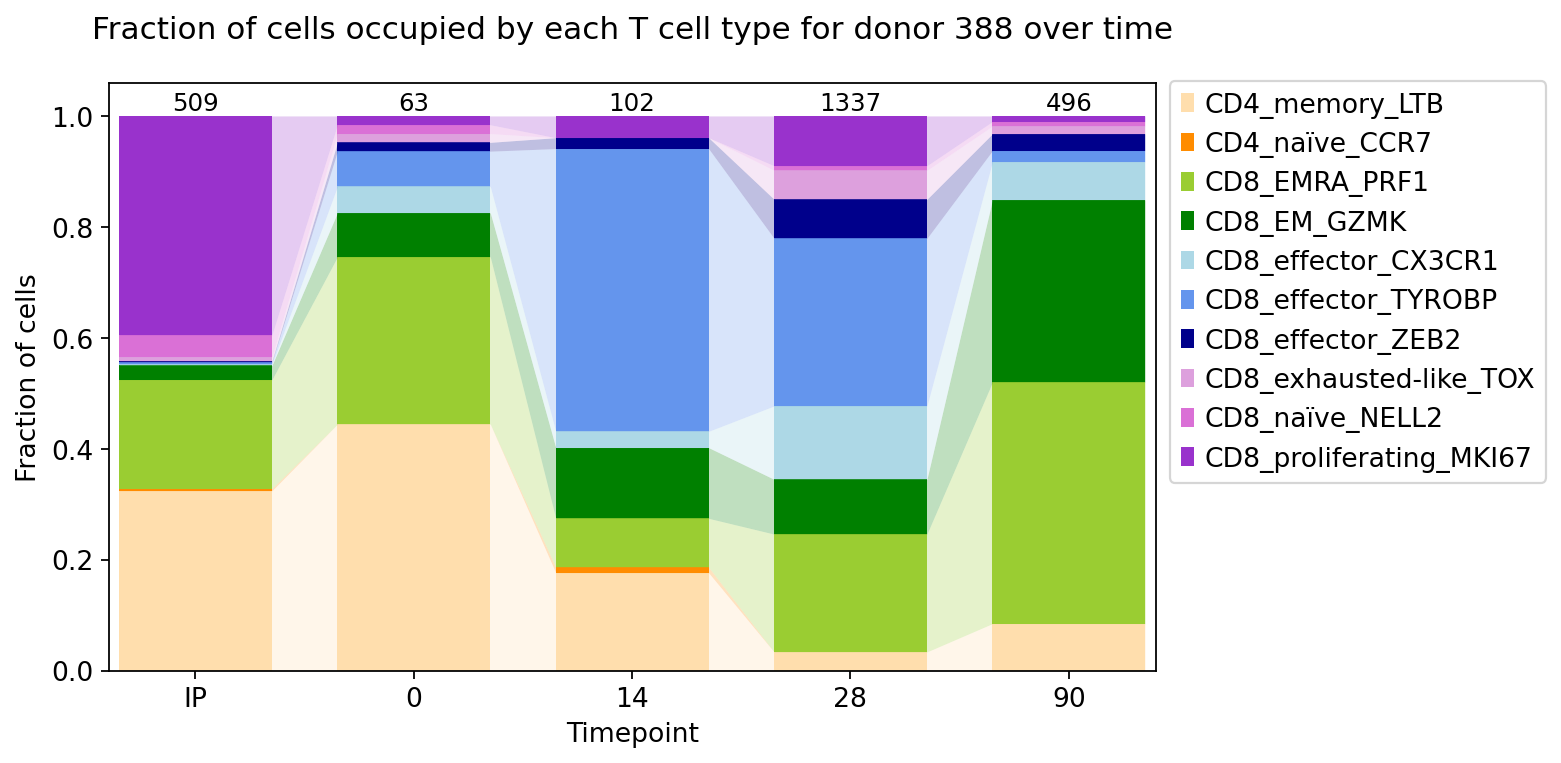

In [36]:
donor = "388"
colors = [
    # "red", 
    "navajowhite", 
    "darkorange", 
    "yellowgreen", 
    "green", 
    "lightblue", 
    "cornflowerblue", 
    "darkblue", 
    "plum", 
    "orchid", 
    "darkorchid", 
    "paleturquoise", 
    # "teal", 
    # "lightgrey", 
    # "lightpink"
]
# timepoints_to_keep_tcells = ['IP', '-6', '0', '14', '28', '90']
timepoints_to_keep_tcells = ['IP', '0', '14', '28', '90']

fracs = plot_fraction_per_sample(
    tcell_adata[(tcell_adata.obs["donor"]==donor) & (tcell_adata.obs["immune_comp_raw_clean"].notnull()) & ~(tcell_adata.obs["immune_comp_raw_clean"].isin(celltypes_to_skip)), :],
    groups="timepoint",
    group_order=timepoints_to_keep_tcells,
    fractions="immune_comp_raw_clean",
    # normalize_to_total=True,
    colors=colors,
    title="Fraction of cells occupied by each T cell type for donor 388 over time",
    xticklabel_rotation=0,
    figsize=(10, 5),
    # legend_on_bottom=True,
    connect_bars=True,
    save=True,
    save_as="donor388_immune_landscape_fractions_over_time"
)

In [37]:
# donor = "406"
# colors = [
#     "red", 
#     "navajowhite", 
#     "darkorange", 
#     "yellowgreen", 
#     "green", 
#     "lightblue", 
#     "cornflowerblue", 
#     "darkblue", 
#     "plum", 
#     "orchid", 
#     "darkorchid", 
#     "paleturquoise", 
#     "teal", 
#     "lightgrey", 
#     "lightpink"
# ]

# fracs = plot_fraction_per_sample(
#     tcell_adata[(tcell_adata.obs["donor"]==donor) & (tcell_adata.obs["immune_comp_raw_clean"].notnull()), :],
#     groups="timepoint",
#     fractions="immune_comp_raw_clean",
#     # normalize_to_total=True,
#     connect_bars=True,
#     colors=colors,
#     title=f"Fraction of cells occupied by each T cell type for donor {donor} over time",
#     xticklabel_rotation=0,
#     figsize=(10, 5)
# )

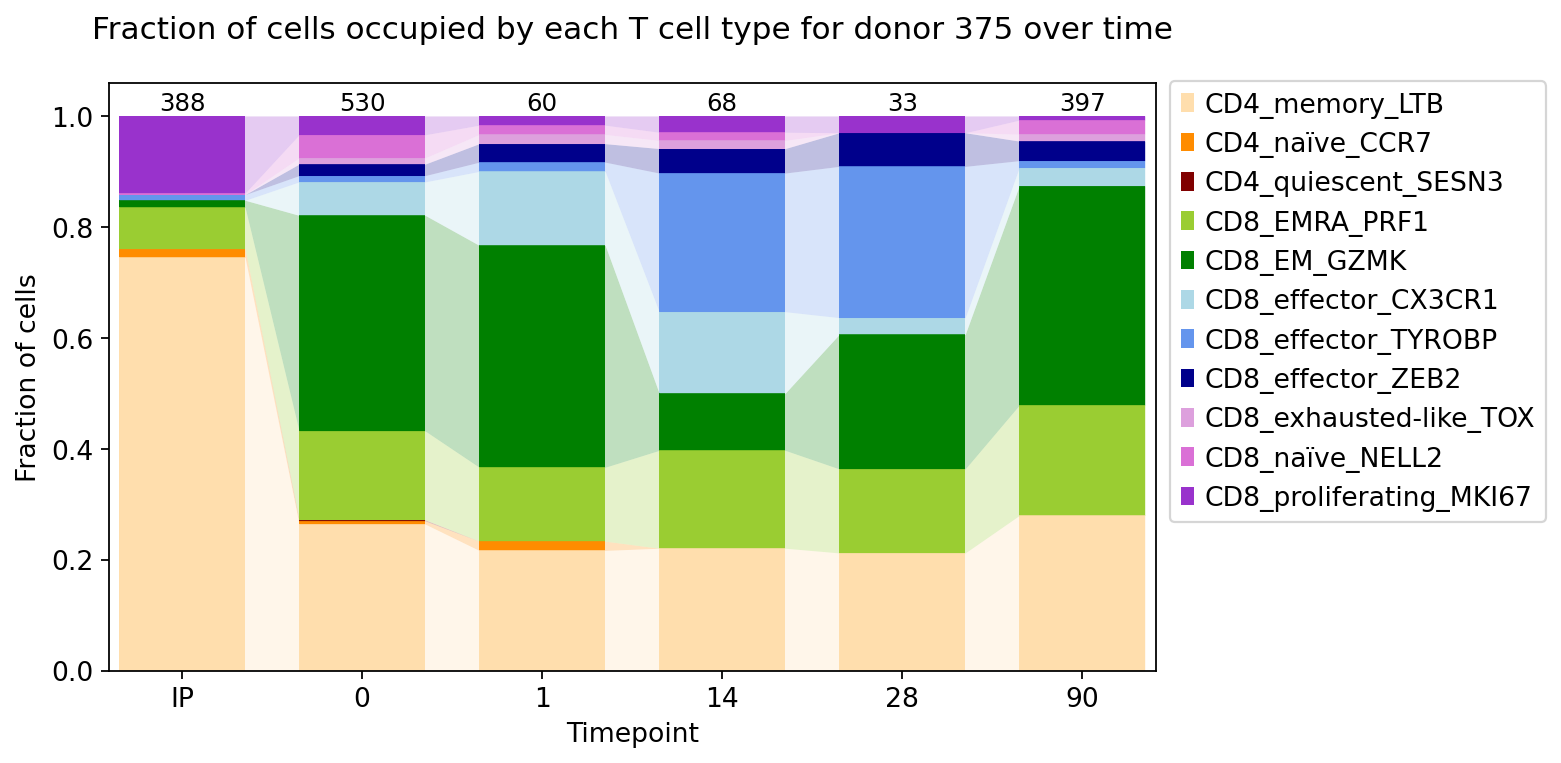

In [40]:
donor = "375"
colors = [
    # "red", 
    "navajowhite", 
    "darkorange", 
    "maroon",
    "yellowgreen", 
    "green", 
    "lightblue", 
    "cornflowerblue", 
    "darkblue", 
    "plum", 
    "orchid", 
    "darkorchid", 
    "paleturquoise", 
    # "teal", 
    # "lightgrey", 
    # "lightpink"
]
tps = ['IP', '0', '1', '14', '28', '90']

fracs = plot_fraction_per_sample(
    tcell_adata[(tcell_adata.obs["donor"]==donor) & (tcell_adata.obs["immune_comp_raw_clean"].notnull()) & ~(tcell_adata.obs["immune_comp_raw_clean"].isin(celltypes_to_skip)), :],
    groups="timepoint",
    group_order=tps,
    fractions="immune_comp_raw_clean",
    # normalize_to_total=True,
    connect_bars=True,
    colors=colors,
    title=f"Fraction of cells occupied by each T cell type for donor {donor} over time",
    xticklabel_rotation=0,
    figsize=(10, 5),
    save=True,
    save_as=f"donor{donor}_immune_landscape_fractions_over_time"
)

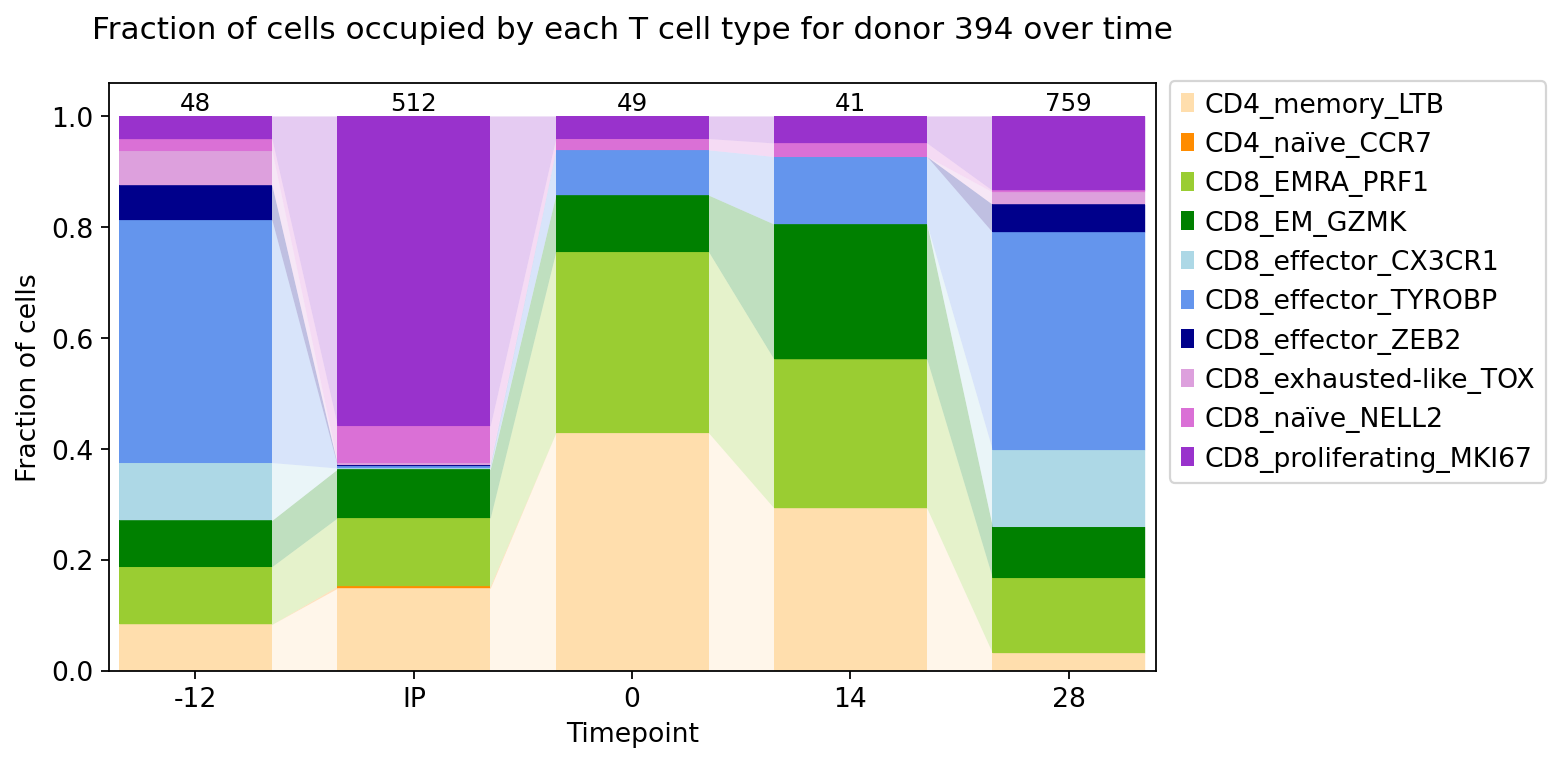

In [41]:
donor = "394"
colors = [
    # "red", 
    "navajowhite", 
    "darkorange", 
    # "maroon",
    "yellowgreen", 
    "green", 
    "lightblue", 
    "cornflowerblue", 
    "darkblue", 
    "plum", 
    "orchid", 
    "darkorchid", 
    "paleturquoise", 
    "teal", 
    "lightgrey", 
    "lightpink"
]
tps = ['-12', 'IP', '0', '14', '28']

fracs = plot_fraction_per_sample(
    tcell_adata[(tcell_adata.obs["donor"]==donor) & (tcell_adata.obs["immune_comp_raw_clean"].notnull()) & ~(tcell_adata.obs["immune_comp_raw_clean"].isin(celltypes_to_skip)), :],
    groups="timepoint",
    group_order=tps,
    fractions="immune_comp_raw_clean",
    # normalize_to_total=True,
    connect_bars=True,
    colors=colors,
    title=f"Fraction of cells occupied by each T cell type for donor {donor} over time",
    xticklabel_rotation=0,
    figsize=(10, 5),
    save=True,
    save_as=f"donor{donor}_immune_landscape_fractions_over_time"
)

In [42]:
# donor = "376"

# colors = [
#     # "red", 
#     "navajowhite", 
#     "darkorange", 
#     # "maroon",
#     "yellowgreen", 
#     "green", 
#     "lightblue", 
#     "cornflowerblue", 
#     "darkblue", 
#     "plum", 
#     "orchid", 
#     "darkorchid", 
#     "paleturquoise", 
#     "teal", 
#     "lightgrey", 
#     "lightpink"
# ]
# # tps = ['-12', 'IP', '0', '14', '28']

# fracs = plot_fraction_per_sample(
#     tcell_adata[(tcell_adata.obs["donor"]==donor) & (tcell_adata.obs["immune_comp_raw_clean"].notnull()), :],
#     groups="timepoint",
#     # group_order=tps,
#     fractions="immune_comp_raw_clean",
#     # normalize_to_total=True,
#     connect_bars=True,
#     colors=colors,
#     title=f"Fraction of cells occupied by each T cell type for donor {donor} over time",
#     xticklabel_rotation=0,
#     figsize=(10, 5),
#     # save=True,
#     # save_as=f"donor{donor}_immune_landscape_fractions_over_time"
# )

In [43]:
# donor = "393"
# colors = [
#     # "red", 
#     "navajowhite", 
#     "darkorange", 
#     # "maroon",
#     "yellowgreen", 
#     "green", 
#     "lightblue", 
#     "cornflowerblue", 
#     "darkblue", 
#     "plum", 
#     "orchid", 
#     "darkorchid", 
#     "paleturquoise", 
#     "teal", 
#     "lightgrey", 
#     "lightpink"
# ]
# # tps = ['-12', 'IP', '0', '14', '28']

# fracs = plot_fraction_per_sample(
#     tcell_adata[(tcell_adata.obs["donor"]==donor) & (tcell_adata.obs["immune_comp_raw_clean"].notnull()), :],
#     groups="timepoint",
#     # group_order=tps,
#     fractions="immune_comp_raw_clean",
#     # normalize_to_total=True,
#     connect_bars=True,
#     colors=colors,
#     title=f"Fraction of cells occupied by each T cell type for donor {donor} over time",
#     xticklabel_rotation=0,
#     figsize=(10, 5),
#     # save=True,
#     # save_as=f"donor{donor}_immune_landscape_fractions_over_time"
# )

In [44]:
# donor = "403"
# colors = [
#     # "red", 
#     "navajowhite", 
#     "darkorange", 
#     # "maroon",
#     "yellowgreen", 
#     "green", 
#     "lightblue", 
#     "cornflowerblue", 
#     "darkblue", 
#     "plum", 
#     "orchid", 
#     "darkorchid", 
#     "paleturquoise", 
#     "teal", 
#     "lightgrey", 
#     "lightpink"
# ]
# tps = ['-12', 'IP', '0', '14', '28']

# fracs = plot_fraction_per_sample(
#     tcell_adata[(tcell_adata.obs["donor"]==donor) & (tcell_adata.obs["immune_comp_raw_clean"].notnull()), :],
#     groups="timepoint",
#     group_order=tps,
#     fractions="immune_comp_raw_clean",
#     # normalize_to_total=True,
#     connect_bars=True,
#     colors=colors,
#     title=f"Fraction of cells occupied by each T cell type for donor {donor} over time",
#     xticklabel_rotation=0,
#     figsize=(10, 5),
#     save=True,
#     save_as=f"donor{donor}_immune_landscape_fractions_over_time"
# )

Save number of T cells per donor per timepoint to inform potential recollection of data:

In [130]:
tcell_adata.obs.groupby(["donor", "timepoint"]).count()["species"].reset_index().rename(columns={"species": "T cell count"}).to_csv("t_cell_nums.csv")